# Imports

In [1]:
# 0) Imports y setup

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.utils as vutils
import torch.nn.functional as F

from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms as transforms

from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj, asarray
from numpy import expand_dims, log, mean, std, exp
from math import floor

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize

c:\Users\karin\anaconda3\envs\gpu311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\karin\AppData\Local\Temp\ipykernel_10752\2943744491.py:20: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.1)
  from scipy.linalg import sqrtm
c:\Users\karin\anaconda3\envs\gpu311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\karin\anaconda3\envs\gpu311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version 

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


In [3]:
# 1) Paths
# Definición de rutas para datos de entrada y salidas del experimento

# Ruta base del proyecto
ROOT_PATH = r"C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection"

# Dataset: imágenes preprocesadas y archivo de etiquetas
IMAGES_DIR = os.path.join(ROOT_PATH, "dataset_120_square")
CSV_PATH   = os.path.join(IMAGES_DIR, "trainLabels.csv")

# Salidas (modelos y muestras generadas)
OUT_ROOT    = r"C:\Proyecto final\Prueba 26"
RUN_DIR     = os.path.join(OUT_ROOT, "wgan_gp_rgb120")
SAMPLES_DIR = os.path.join(RUN_DIR, "samples")

# Crear carpeta de muestras si no existe
os.makedirs(SAMPLES_DIR, exist_ok=True)

print("IMAGES_DIR:", IMAGES_DIR)
print("CSV_PATH:", CSV_PATH)
print("RUN_DIR:", RUN_DIR)
print("SAMPLES_DIR:", SAMPLES_DIR)
print("cwd:", os.getcwd())

IMAGES_DIR: C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection\dataset_120_square
CSV_PATH: C:\Proyecto final\Prueba 19_retinal-data-augmentation-GAN\diabetic-retinopathy-detection\dataset_120_square\trainLabels.csv
RUN_DIR: C:\Proyecto final\Prueba 26\wgan_gp_rgb120
SAMPLES_DIR: C:\Proyecto final\Prueba 26\wgan_gp_rgb120\samples
cwd: c:\Proyecto final\Prueba 26


In [4]:
# 2) Dataset

df = pd.read_csv(CSV_PATH)
df["side"] = df["image"].str.split("_").str[1]
df.head()

image  level   side
0   10_left      0   left
1  10_right      0  right
2   13_left      0   left
3  13_right      0  right
4   15_left      1   left

In [5]:
# Cantidad por severidad y lado del ojo
df[['side','level']].value_counts()

side   level
right  0        12939
left   0        12871
       2         2702
right  2         2590
       1         1231
left   1         1212
right  3          448
left   3          425
right  4          355
left   4          353
Name: count, dtype: int64

In [6]:
class Dataset(Dataset):
    """
    Dataset para APTOS.
    Devuelve (imagen, condición), donde condición = severidad (0–4).
    En este experimento NO diferenciamos el lado (left/right).
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
        self.errCounter = 0

    def __len__(self):
        return len(self.dataframe)

    def processcondition(self, severity, side):
        condition = f"{int(severity)}{side}"
        switch = {
            "0right": 0, "1right": 1, "2right": 2, "3right": 3, "4right": 4,
            "0left":  0, "1left":  1, "2left":  2, "3left":  3, "4left":  4,
        }
        return switch.get(condition, 0)

    def __getitem__(self, idx):
        img_filename = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        severity = self.dataframe.iloc[idx, 1]
        side = self.dataframe.iloc[idx, 2]

        try:
            image = Image.open(img_filename + ".jpeg").convert("RGB")
            image_tensor = self.transform(image)
            condition = torch.tensor(self.processcondition(severity, side), dtype=torch.long)
            return image_tensor, condition

        except FileNotFoundError:
            self.errCounter += 1
            print("File not found")
            return torch.zeros([3, 120, 120]), torch.tensor(0, dtype=torch.long)

In [7]:
# Preparación del dataset y DataLoader para entrenamiento

BATCH_SIZE = 16

# Carga del dataset y daloader
dataset = Dataset(dataframe=df, image_dir=IMAGES_DIR)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Modelos del Generador y Crítico

Siguiendo **WGAN-GP**, el discriminador se reemplaza por un *crítico* C(x,y) que asigna un score real.
El entrenamiento busca aproximar la distancia de Wasserstein entre datos reales y generados.
Para imponer la restricción 1-Lipschitz se usa *gradient penalty* (GP) sobre interpolaciones entre muestras reales y falsas.
El generador se entrena maximizando el score del crítico sobre las muestras generadas.

In [8]:
# 4) Modelos: cWGAN-GP (Generador y Crítico)

class cWGAN_Generator(nn.Module):
    """
    Generador condicional (cWGAN-GP).
    Recibe un vector de ruido z concatenado con el embedding de la condición
    (severidad + lado) y genera una imagen RGB mediante una MLP.
    La salida utiliza Tanh para producir valores en el rango [-1,1].
    """
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape): # (n_channels, height, width)
        super(cWGAN_Generator, self).__init__()
        self.img_shape = img_shape
        self.label_emb = nn.Embedding(n_classes, embedding_dim)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + embedding_dim, 2**6, normalize=False),
            *block(2**6, 2**7),
            *block(2**7, 2**7),
            *block(2**7, 2**8),
            *block(2**8, 2**7),
            *block(2**7, 2**6),
            nn.Linear(2**6 , int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concatenar ruido latente y embedding de la condición
        gen_input = torch.cat((self.label_emb(labels), z), -1)
        img = self.model(gen_input)
        img = img.view(img.shape[0], * self.img_shape)
        return img

class cWGAN_Citrico(nn.Module):
    """
    Crítico condicional (cWGAN-GP).
    Recibe la imagen y su condición (severidad + lado) y produce un score real.
    """
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape):
        super(cWGAN_Citrico, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim + int(np.prod(img_shape)), 2**6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**6, 2**6),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**6, 1),
        )

    def forward(self, img, labels):
        # Concatenar imagen aplanada y embedding de la condición
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# Loss, métricas y loop de entrenamiento

In [9]:
# Hiperparámetros del modelo y del entrenamiento

latent_dim = 20                 # Dimensión del ruido latente z
n_classes = 5                   # Número de condiciones (severidad 0–4)
embedding_dim = 20              # Dimensión del embedding de la condición
height = 120
width = 120
img_shape = (3, height, width)  # Forma de la imagen (RGB 120×120)
lambda_gp = 10                  # Peso del gradient penalty (WGAN-GP)
num_epochs = 100                # Número total de épocas de entrenamiento
n_critic = 5                    # Actualizaciones del crítico por cada actualización del generador

In [10]:
# Selección de tipo de tensor según el dispositivo (CPU / GPU)
Tensor = torch.cuda.FloatTensor if DEVICE == "cuda" else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if DEVICE == "cuda" else torch.LongTensor

In [11]:
def to_01(x):
    # Convierte un tensor de imágenes a rango [0,1] para visualización/guardado (salida en [-1,1])
    x = x.detach().cpu().float()
    # si viene en [-1,1], pasarlo a [0,1]
    if x.min().item() < 0:
        x = (x + 1.0) / 2.0
    return x.clamp(0, 1)

def show_grid(images_tensor, title=None, nrow=4):
    # Muestra una grilla de imágenes en el notebook
    if images_tensor is None:
        print("No hay imágenes para mostrar.")
        return

    imgs = to_01(images_tensor)
    grid = vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=False)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

def save_grid(images_tensor, out_path, nrow=4):
    # Guarda una grilla de imágenes en un archivo
    imgs = to_01(images_tensor)
    vutils.save_image(imgs, out_path, nrow=nrow, normalize=False)

In [12]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP.
       Warning: It doesn't compute the gradient w.r.t the labels, only w.r.t
       the interpolated real and fake samples, as in the WGAN GP paper.
    """
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(DEVICE)
    labels = labels.type(LongTensor).to(DEVICE)
    # Get random interpolation between real and fake samples

    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0).to(DEVICE)
    fake.requires_grad = False
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

In [13]:
def wasserstein_loss( discriminator, real_imgs_d, fake_imgs_d,
                        conditions_d, real_validity, fake_validity):
    # Gradient penalty
    gradient_penalty = compute_gradient_penalty(
                        discriminator, real_imgs_d, fake_imgs_d,
                        conditions_d)
    return -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

In [14]:
def plot_epoch_monitor(epoch, history_so_far, show_every=1):
    """
    history_so_far: dict con listas (d_loss, g_loss, W_hat, gp)
    """
    if (epoch + 1) % show_every != 0:
        return

    plt.figure(figsize=(12,4))

    # (A) W_hat + GP
    plt.subplot(1,2,1)
    plt.plot(history_so_far["W_hat"], label="W_hat")
    plt.plot(history_so_far["gp"], label="GP")
    plt.title(f"Epoch {epoch+1}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # (B) Losses (contexto)
    plt.subplot(1,2,2)
    plt.plot(history_so_far["d_loss"], label="D_loss")
    plt.plot(history_so_far["g_loss"], label="G_loss")
    plt.title("Losses")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [15]:
def train(folder_path, generator, discriminator, optimizer_G, optimizer_D):
  generator.train()

  d_hist = []
  g_hist = []
  w_hist = []
  gp_hist = []

  fixed_z = Tensor(np.random.normal(0, 1, (16, latent_dim))).to(DEVICE)
  fixed_cond0 = torch.full((16,), 0, dtype=torch.long, device=DEVICE)  
  fixed_cond4 = torch.full((16,), 4, dtype=torch.long, device=DEVICE)  
  os.makedirs(SAMPLES_DIR, exist_ok=True)

  for epoch in range(num_epochs):
      os.makedirs(folder_path, exist_ok=True)

      # Acumuladores de métricas por época
      d_epoch = []
      g_epoch = []
      w_epoch = []
      gp_epoch = []

      pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
      for i, (real_images, conditions) in enumerate(pbar):
          
          # --- Entrenamiento del crítico ---
          for d in discriminator.parameters():
            d.requires_grad = True

          discriminator.zero_grad()
          batch_size = real_images.shape[0]

          real_imgs = real_images.type(Tensor).to(DEVICE)
          conditions = conditions.type(LongTensor).to(DEVICE)

          optimizer_D.zero_grad()

          z = Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(DEVICE)
          fake_imgs = generator(z, conditions).to(DEVICE)

          real_validity = discriminator(real_imgs, conditions)
          fake_validity = discriminator(fake_imgs, conditions)

          d_loss = wasserstein_loss(discriminator, real_imgs.data, fake_imgs.data,
                                    conditions.data, real_validity, fake_validity)

          d_loss.backward()
          optimizer_D.step()

          # Métricas WGAN-GP (monitoreo)
          C_x = real_validity.mean().item()
          C_z = fake_validity.mean().item()
          W_hat = C_x - C_z       # estimación de la distancia de Wasserstein
          gp_val = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, conditions.data).item()

          d_epoch.append(d_loss.item())
          w_epoch.append(W_hat)
          gp_epoch.append(gp_val)

          optimizer_G.zero_grad()

          # --- Entrenamiento del generador (cada n_critic pasos) ---
          if i % n_critic == 0:
              for d in discriminator.parameters():
                d.requires_grad = False
              generator.zero_grad()

              fake_imgs = generator(z, conditions)
              fake_validity = discriminator(fake_imgs, conditions)

              g_loss = -torch.mean(fake_validity)

              g_loss.backward()
              optimizer_G.step()

              g_epoch.append(g_loss.item())

              pbar.set_description(
                  "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [W_hat: %0.2f] [GP: %0.2f]"
                  % (epoch+1, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item(), W_hat, gp_val)
              )

      pbar.close()

      # Guardar métricas promedio por época para monitoreo del entrenamiento
      d_hist.append(float(np.mean(d_epoch)) if len(d_epoch) else np.nan)    # pérdida del crítico
      g_hist.append(float(np.mean(g_epoch)) if len(g_epoch) else np.nan)    # pérdida del generador
      w_hist.append(float(np.mean(w_epoch)) if len(w_epoch) else np.nan)    # estimación de distancia de Wasserstein
      gp_hist.append(float(np.mean(gp_epoch)) if len(gp_epoch) else np.nan) # gradient penalty

      # Mostrar resumen de métricas por época
      print(f"[Epoch {epoch+1}/{num_epochs}] "
      f"D_loss={d_hist[-1]:.4f} | G_loss={g_hist[-1]:.4f} | "
      f"W_hat={w_hist[-1]:.4f} | GP={gp_hist[-1]:.4f}")

      # ---- MONITOREO POR EPOCH ----
      plot_epoch_monitor(
          epoch,
          {"d_loss": d_hist, "g_loss": g_hist, "W_hat": w_hist, "gp": gp_hist},
          show_every=5   # 1 = cada epoch, 5 = cada 5 epochs, etc.
      )

      if (epoch+1) % 10 == 0:
        torch.save(generator.state_dict(), os.path.join(folder_path, f"generator_1_{epoch+1}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(folder_path, f"discriminator_1_{epoch+1}.pth"))
      
      # Cada 5 épocas: generar y guardar muestras fijas para monitorear el progreso (mismo z, mismas condiciones)
      if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake0 = generator(fixed_z, fixed_cond0).detach().cpu()    # cond=0
            fake4 = generator(fixed_z, fixed_cond4).detach().cpu()    # cond=4

        p0 = os.path.join(SAMPLES_DIR, f"samples_s0r_e{epoch+1:03d}.png")
        p4 = os.path.join(SAMPLES_DIR, f"samples_s4_e{epoch+1:03d}.png")

        # Guardar grillas (salida Tanh en [-1,1])
        vutils.save_image(fake0, p0, nrow=4, normalize=True, value_range=(-1, 1))
        vutils.save_image(fake4, p4, nrow=4, normalize=True, value_range=(-1, 1))

        # Mostrar (imágenes generadas: severidad 4)
        img = plt.imread(p4)
        plt.figure(figsize=(4,4)); plt.axis("off"); plt.imshow(img); plt.show()

  return {"d_loss": d_hist, "g_loss": g_hist, "W_hat": w_hist, "gp": gp_hist}

In [16]:
# 6) Inicialización + entrenamiento (cWGAN-GP)

generator = cWGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(DEVICE)
discriminator = cWGAN_Citrico(n_classes, latent_dim, embedding_dim, img_shape).to(DEVICE)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

C:\Users\karin\AppData\Local\Temp\ipykernel_10752\3558449342.py:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:80.)
  fixed_z = Tensor(np.random.normal(0, 1, (16, latent_dim))).to(DEVICE)
Epoch 1/100:   0%|          | 0/2196 [00:00<?, ?it/s]c:\Users\karin\anaconda3\envs\gpu311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 1/100] D_loss=-66.4679 | G_loss=-29.9761 | W_hat=82.8163 | GP=1.6426


[Epoch 2/100] D_loss=-34.7652 | G_loss=-18.0305 | W_hat=43.1417 | GP=0.8432


[Epoch 3/100] D_loss=-27.5333 | G_loss=-8.8132 | W_hat=33.5624 | GP=0.6031


[Epoch 4/100] D_loss=-26.4554 | G_loss=4.6263 | W_hat=32.2324 | GP=0.5839


[Epoch 5/100] D_loss=-24.4335 | G_loss=0.5355 | W_hat=29.6987 | GP=0.5407


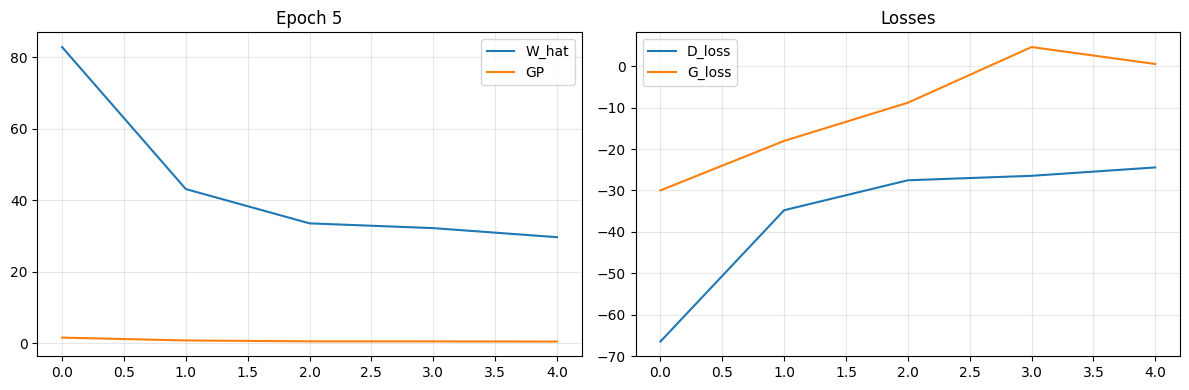

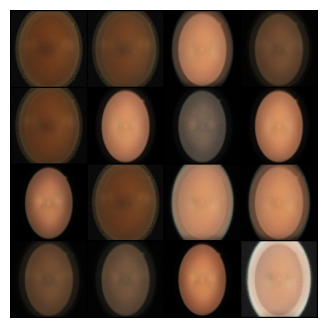

[Epoch 6/100] D_loss=-20.3381 | G_loss=-8.8431 | W_hat=25.2866 | GP=0.5014


[Epoch 7/100] D_loss=-17.4637 | G_loss=-10.0783 | W_hat=21.7571 | GP=0.4258


[Epoch 8/100] D_loss=-14.8147 | G_loss=-10.2970 | W_hat=18.7664 | GP=0.4032


[Epoch 9/100] D_loss=-13.2243 | G_loss=-5.2474 | W_hat=17.1185 | GP=0.3918


[Epoch 10/100] D_loss=-11.7180 | G_loss=0.4365 | W_hat=15.4897 | GP=0.3786


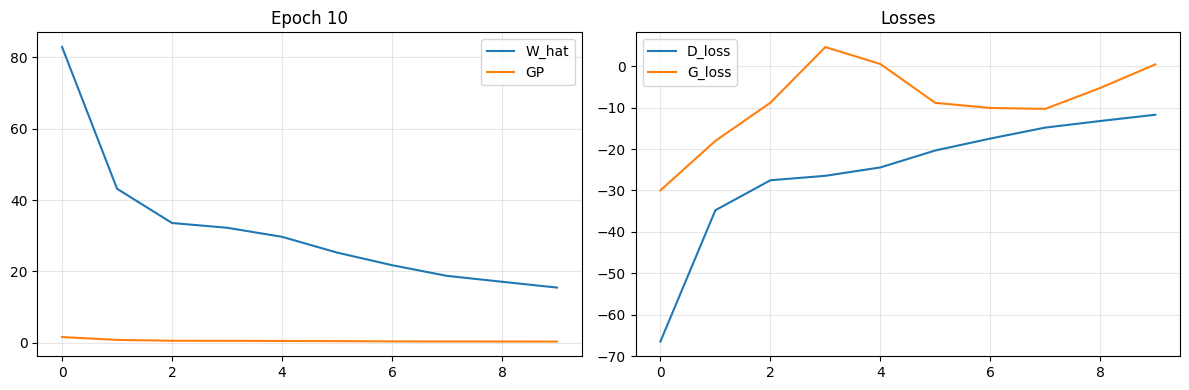

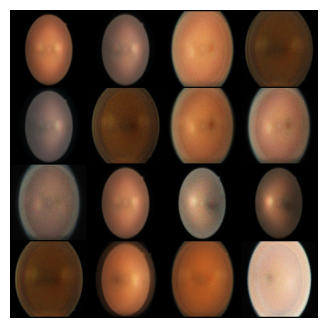

[Epoch 11/100] D_loss=-10.5562 | G_loss=8.7055 | W_hat=14.1185 | GP=0.3627


[Epoch 12/100] D_loss=-9.4040 | G_loss=8.3197 | W_hat=12.8285 | GP=0.3466


[Epoch 13/100] D_loss=-8.8113 | G_loss=1.3428 | W_hat=12.0515 | GP=0.3277


[Epoch 14/100] D_loss=-7.7406 | G_loss=9.6630 | W_hat=10.9947 | GP=0.3258


[Epoch 15/100] D_loss=-7.4272 | G_loss=6.3682 | W_hat=10.7154 | GP=0.3271


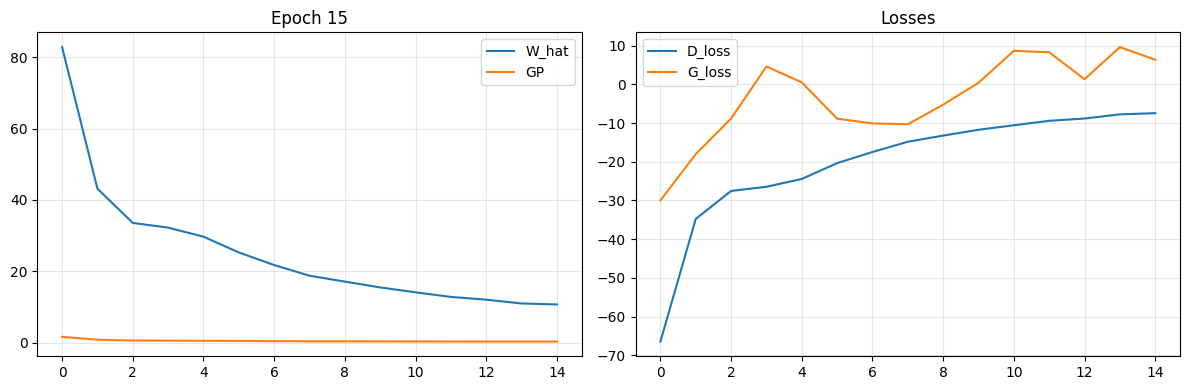

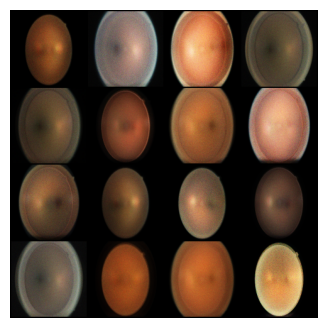

[Epoch 16/100] D_loss=-7.0511 | G_loss=8.5920 | W_hat=10.3032 | GP=0.3271


[Epoch 17/100] D_loss=-5.8854 | G_loss=8.9553 | W_hat=8.9409 | GP=0.3007


[Epoch 18/100] D_loss=-5.7376 | G_loss=5.6443 | W_hat=8.7365 | GP=0.2947


[Epoch 19/100] D_loss=-5.2290 | G_loss=3.9294 | W_hat=8.2621 | GP=0.3005


[Epoch 20/100] D_loss=-4.9417 | G_loss=6.0675 | W_hat=8.0000 | GP=0.3106


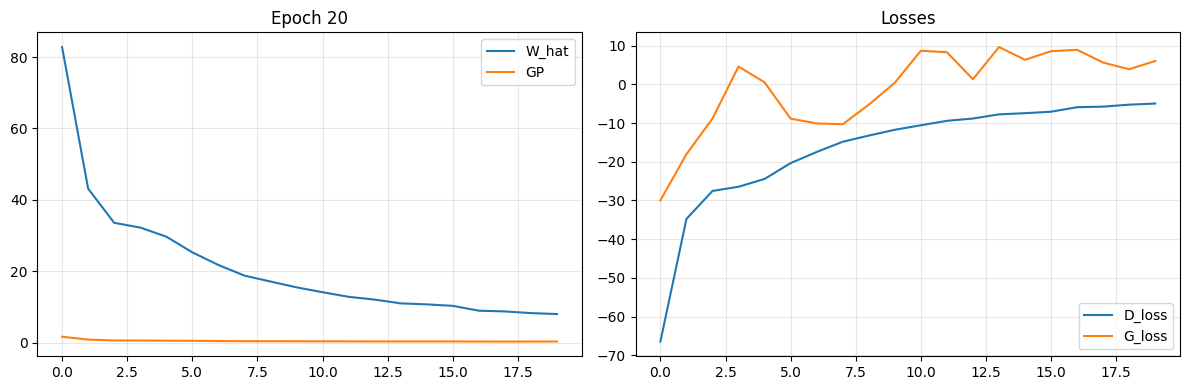

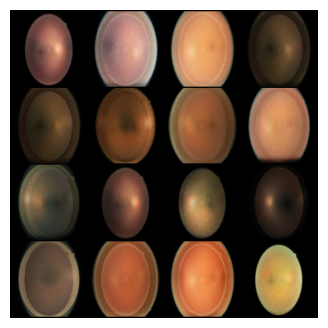

[Epoch 21/100] D_loss=-4.4948 | G_loss=12.2321 | W_hat=7.4802 | GP=0.2974


[Epoch 22/100] D_loss=-3.6230 | G_loss=6.0603 | W_hat=6.5727 | GP=0.2964


[Epoch 23/100] D_loss=-3.1825 | G_loss=14.6991 | W_hat=6.0394 | GP=0.2797


[Epoch 24/100] D_loss=-3.6711 | G_loss=15.3186 | W_hat=6.9102 | GP=0.3159


[Epoch 25/100] D_loss=-2.5250 | G_loss=30.1012 | W_hat=5.4372 | GP=0.2879


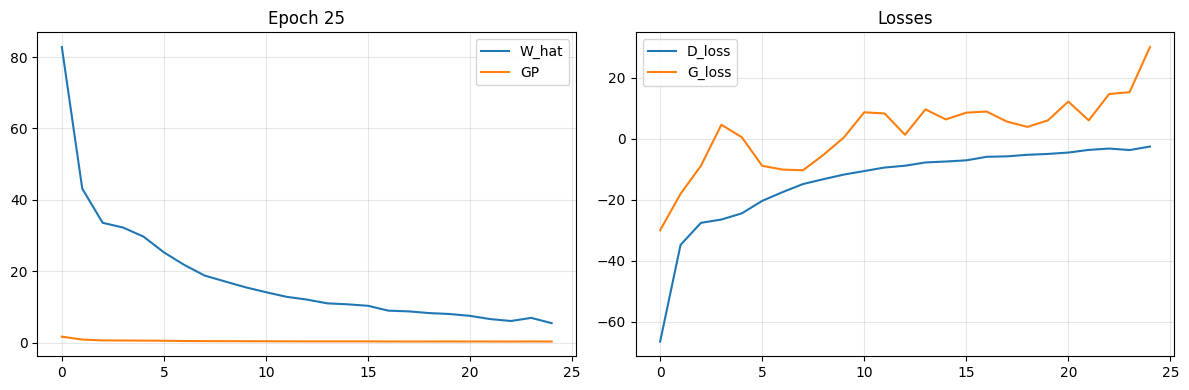

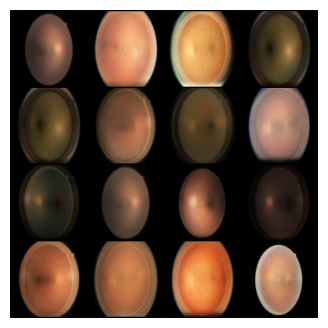

[Epoch 26/100] D_loss=-1.9323 | G_loss=22.1665 | W_hat=5.0066 | GP=0.3155


[Epoch 27/100] D_loss=-2.0028 | G_loss=19.5287 | W_hat=5.4143 | GP=0.3318


[Epoch 28/100] D_loss=-0.7073 | G_loss=11.0578 | W_hat=3.7474 | GP=0.2967


[Epoch 29/100] D_loss=-0.9192 | G_loss=6.4026 | W_hat=4.1018 | GP=0.3239


[Epoch 30/100] D_loss=-0.4322 | G_loss=17.8682 | W_hat=3.5092 | GP=0.3004


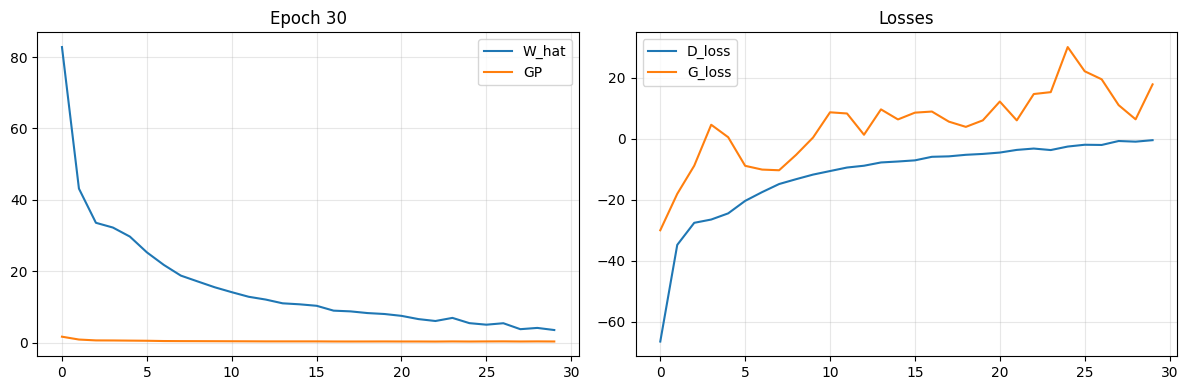

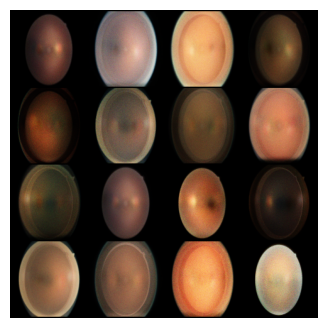

[Epoch 31/100] D_loss=-0.2051 | G_loss=14.0855 | W_hat=3.3681 | GP=0.3207


[Epoch 32/100] D_loss=0.4124 | G_loss=-2.0919 | W_hat=2.7950 | GP=0.3183


[Epoch 33/100] D_loss=0.8355 | G_loss=16.1117 | W_hat=2.5216 | GP=0.3282


[Epoch 34/100] D_loss=0.5933 | G_loss=1.1465 | W_hat=3.0620 | GP=0.3589


[Epoch 35/100] D_loss=0.9434 | G_loss=4.3798 | W_hat=2.7177 | GP=0.3627


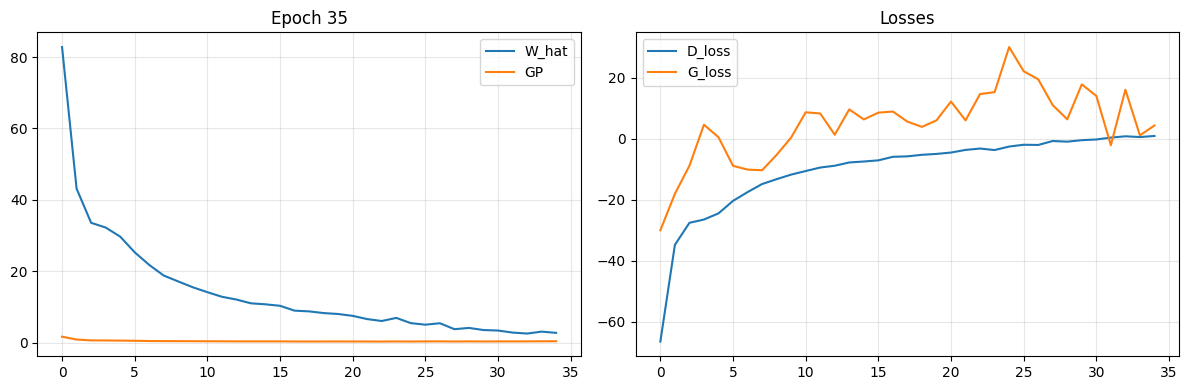

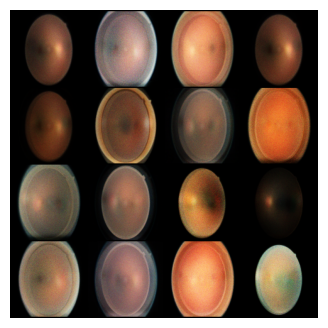

[Epoch 36/100] D_loss=1.6860 | G_loss=7.7208 | W_hat=1.9843 | GP=0.3626


[Epoch 37/100] D_loss=2.1828 | G_loss=10.0842 | W_hat=1.5883 | GP=0.3689


[Epoch 38/100] D_loss=2.7018 | G_loss=-11.6576 | W_hat=0.7406 | GP=0.3413


[Epoch 39/100] D_loss=3.2263 | G_loss=5.6562 | W_hat=0.9893 | GP=0.4203


[Epoch 40/100] D_loss=3.2310 | G_loss=-7.2843 | W_hat=0.7288 | GP=0.3969


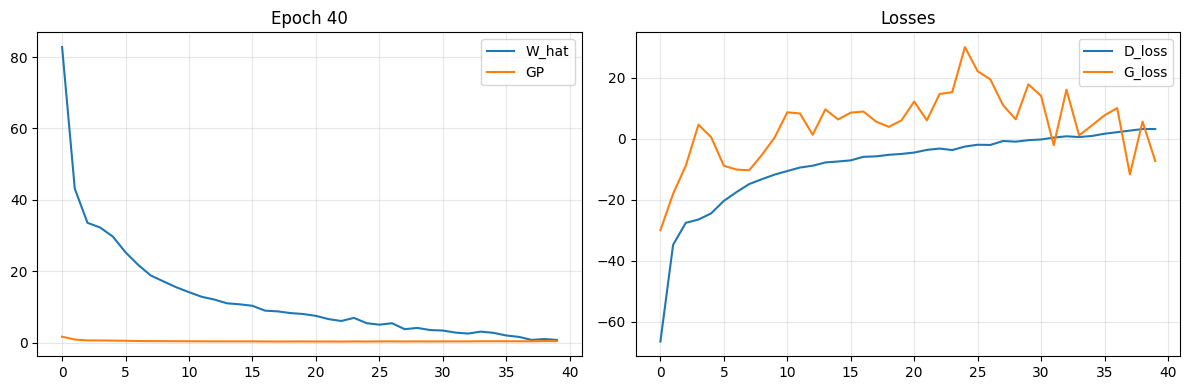

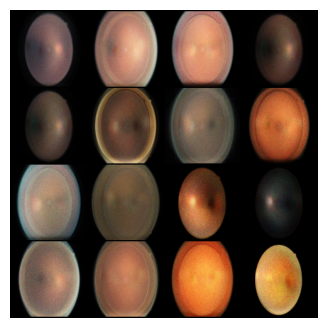

[Epoch 41/100] D_loss=2.5398 | G_loss=44.0856 | W_hat=1.7547 | GP=0.4233


[Epoch 42/100] D_loss=3.6998 | G_loss=-9.3650 | W_hat=0.3562 | GP=0.3968


[Epoch 43/100] D_loss=2.8832 | G_loss=-25.1509 | W_hat=1.3934 | GP=0.4162


[Epoch 44/100] D_loss=4.3698 | G_loss=-2.2288 | W_hat=-0.3762 | GP=0.3953


[Epoch 45/100] D_loss=3.1407 | G_loss=3.1232 | W_hat=0.8535 | GP=0.3941


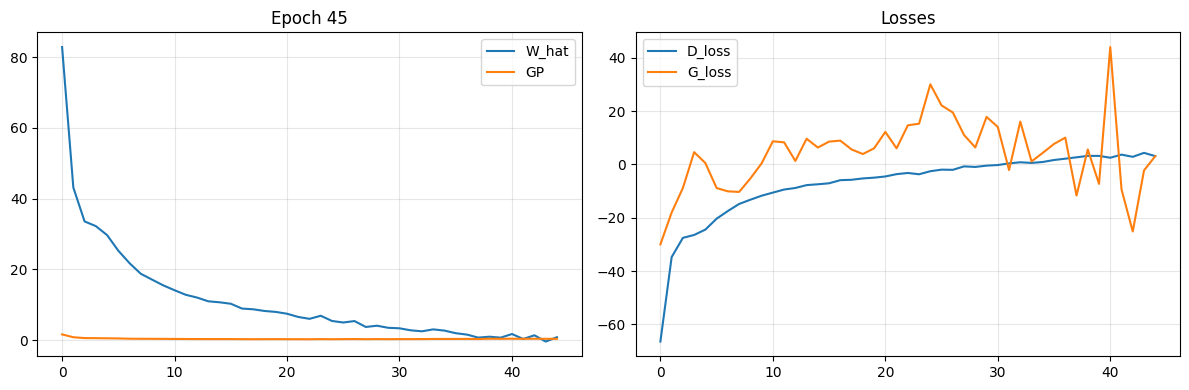

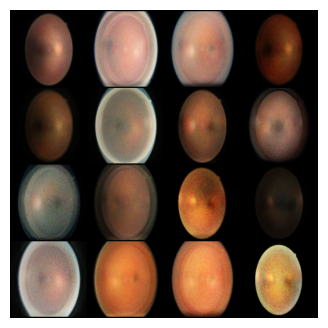

[Epoch 46/100] D_loss=4.7086 | G_loss=-18.9788 | W_hat=-0.3031 | GP=0.4467


[Epoch 47/100] D_loss=2.3234 | G_loss=-12.3544 | W_hat=1.2003 | GP=0.3504


[Epoch 48/100] D_loss=3.3450 | G_loss=11.8399 | W_hat=0.6906 | GP=0.4060


[Epoch 49/100] D_loss=4.3151 | G_loss=-0.5743 | W_hat=-0.0928 | GP=0.4071


[Epoch 50/100] D_loss=4.2546 | G_loss=-3.8814 | W_hat=-0.1199 | GP=0.4111


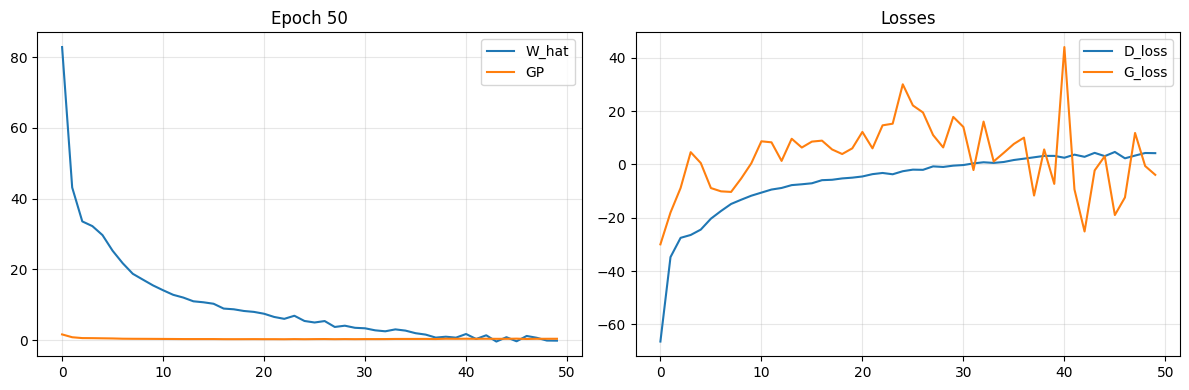

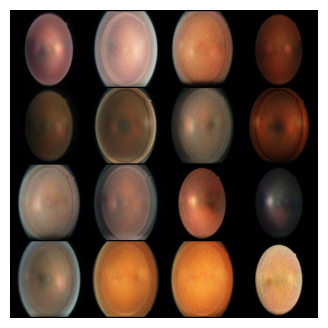

[Epoch 51/100] D_loss=3.4404 | G_loss=11.3401 | W_hat=0.7700 | GP=0.4175


[Epoch 52/100] D_loss=3.9728 | G_loss=-0.6909 | W_hat=0.1179 | GP=0.4098


[Epoch 53/100] D_loss=3.0935 | G_loss=-0.8872 | W_hat=0.8900 | GP=0.3931


[Epoch 54/100] D_loss=3.2289 | G_loss=0.4561 | W_hat=0.7852 | GP=0.3951


[Epoch 55/100] D_loss=3.2602 | G_loss=-5.7980 | W_hat=0.6797 | GP=0.3908


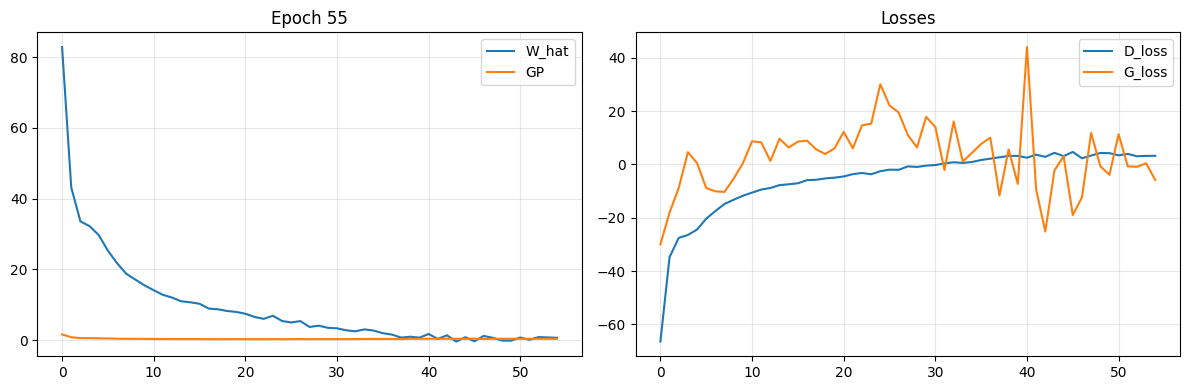

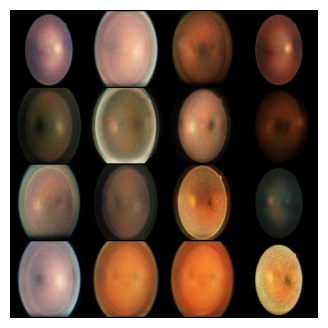

[Epoch 56/100] D_loss=3.4117 | G_loss=-13.7976 | W_hat=1.1183 | GP=0.4407


[Epoch 57/100] D_loss=4.0992 | G_loss=6.4277 | W_hat=0.0833 | GP=0.4127


[Epoch 58/100] D_loss=4.0390 | G_loss=-14.8733 | W_hat=-0.1330 | GP=0.3839


[Epoch 59/100] D_loss=2.5390 | G_loss=-3.3537 | W_hat=1.5824 | GP=0.4103


[Epoch 60/100] D_loss=2.7883 | G_loss=-24.7056 | W_hat=1.6673 | GP=0.4425


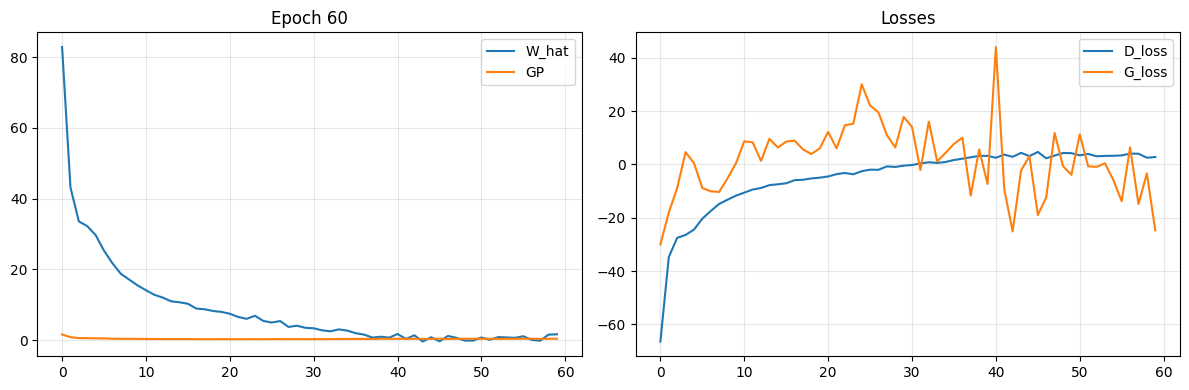

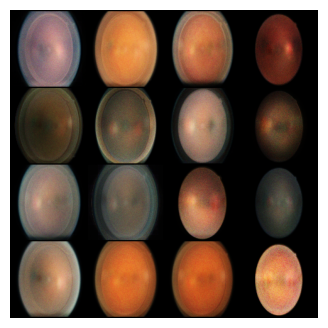

[Epoch 61/100] D_loss=2.5591 | G_loss=-24.6257 | W_hat=2.7664 | GP=0.5194


[Epoch 62/100] D_loss=3.4793 | G_loss=59.9987 | W_hat=2.1750 | GP=0.5516


[Epoch 63/100] D_loss=4.3156 | G_loss=53.3181 | W_hat=-0.8596 | GP=0.3353


[Epoch 64/100] D_loss=5.6878 | G_loss=-108.5840 | W_hat=-2.2308 | GP=0.3485


[Epoch 65/100] D_loss=0.9949 | G_loss=3.0081 | W_hat=3.8993 | GP=0.5003


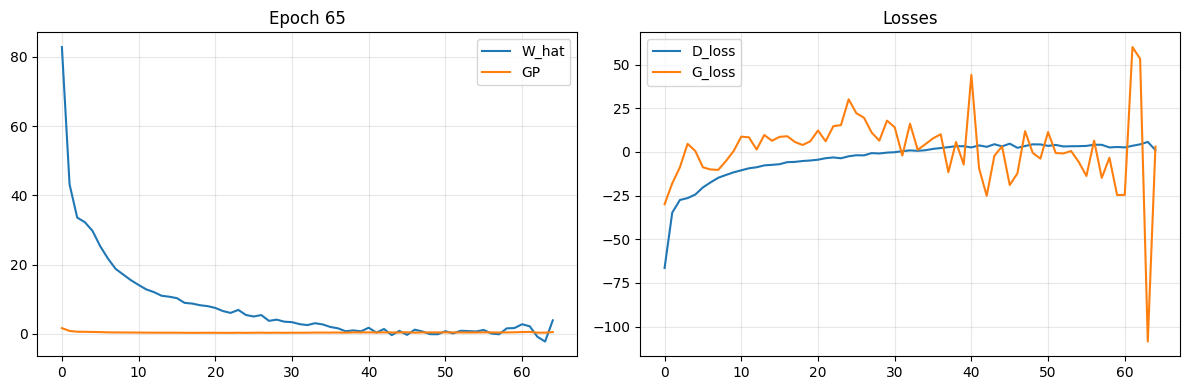

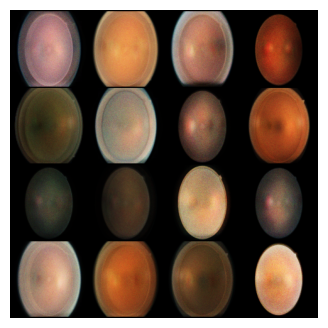

[Epoch 66/100] D_loss=3.7132 | G_loss=103.4988 | W_hat=0.5916 | GP=0.4188


[Epoch 67/100] D_loss=4.6598 | G_loss=83.3445 | W_hat=-1.1723 | GP=0.3473


[Epoch 68/100] D_loss=4.4399 | G_loss=-12.0543 | W_hat=-1.3807 | GP=0.2983


[Epoch 69/100] D_loss=2.0440 | G_loss=-24.0240 | W_hat=2.3747 | GP=0.4381


[Epoch 70/100] D_loss=3.6542 | G_loss=-21.7918 | W_hat=1.0768 | GP=0.4789


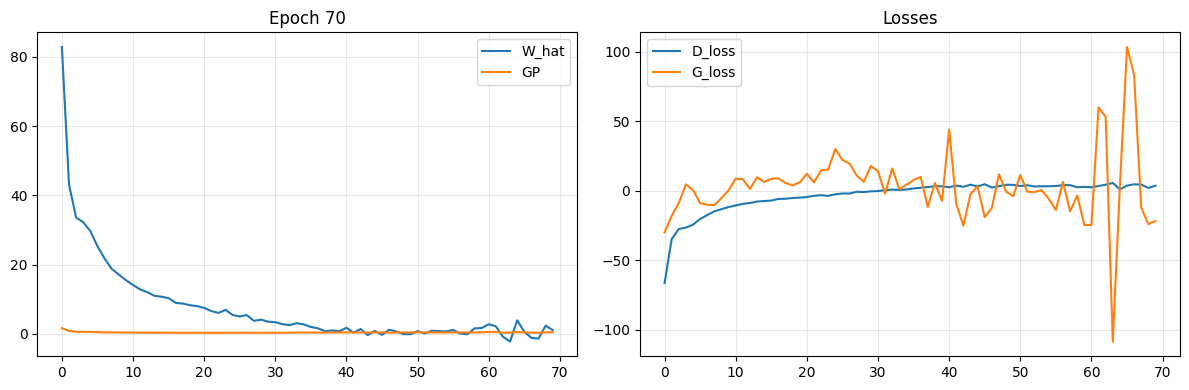

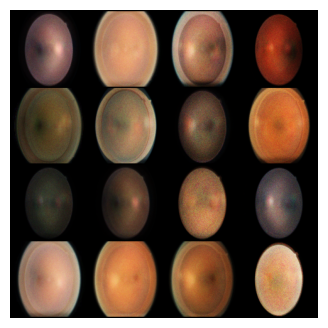

[Epoch 71/100] D_loss=3.8700 | G_loss=-24.5263 | W_hat=1.0300 | GP=0.4733


[Epoch 72/100] D_loss=6.3427 | G_loss=-57.9201 | W_hat=-2.7637 | GP=0.3471


[Epoch 73/100] D_loss=2.1174 | G_loss=-82.9815 | W_hat=2.0534 | GP=0.4186


[Epoch 74/100] D_loss=1.7894 | G_loss=-112.7401 | W_hat=3.8265 | GP=0.5640


[Epoch 75/100] D_loss=4.8074 | G_loss=129.7743 | W_hat=1.7150 | GP=0.6589


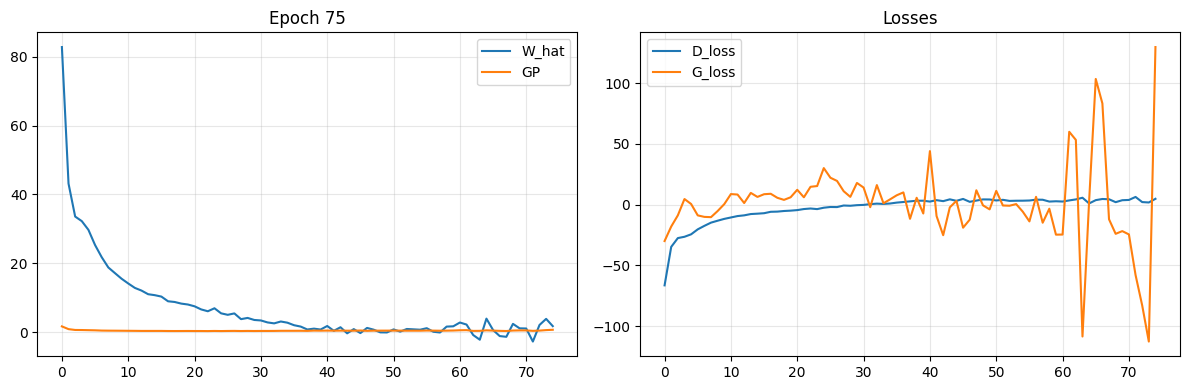

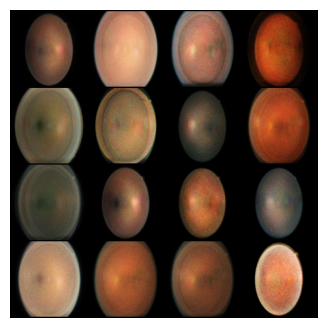

[Epoch 76/100] D_loss=7.6923 | G_loss=156.3732 | W_hat=-2.5898 | GP=0.5167


[Epoch 77/100] D_loss=0.6808 | G_loss=145.7850 | W_hat=5.5107 | GP=0.6083


[Epoch 78/100] D_loss=2.4409 | G_loss=41.3309 | W_hat=4.1755 | GP=0.6386


[Epoch 79/100] D_loss=-0.2129 | G_loss=-121.3214 | W_hat=10.1055 | GP=1.0035


[Epoch 80/100] D_loss=-5.1176 | G_loss=-530.7908 | W_hat=14.7801 | GP=1.0106


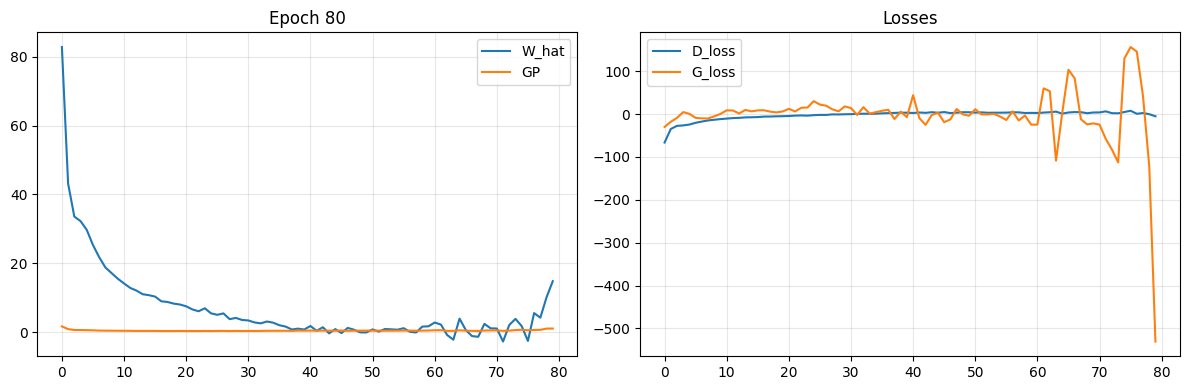

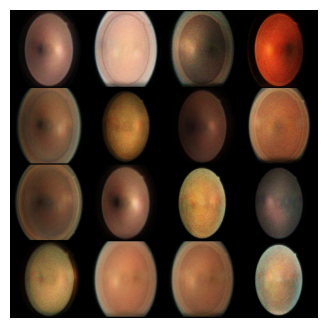

[Epoch 81/100] D_loss=5.8599 | G_loss=174.0903 | W_hat=2.6941 | GP=0.8868


[Epoch 82/100] D_loss=-0.7186 | G_loss=-30.1384 | W_hat=10.9964 | GP=1.0460


[Epoch 83/100] D_loss=7.5644 | G_loss=-207.9653 | W_hat=3.0073 | GP=1.0470


[Epoch 84/100] D_loss=2.0929 | G_loss=156.0484 | W_hat=10.6981 | GP=1.2869


[Epoch 85/100] D_loss=-8.0049 | G_loss=-0.8170 | W_hat=24.8392 | GP=1.5654


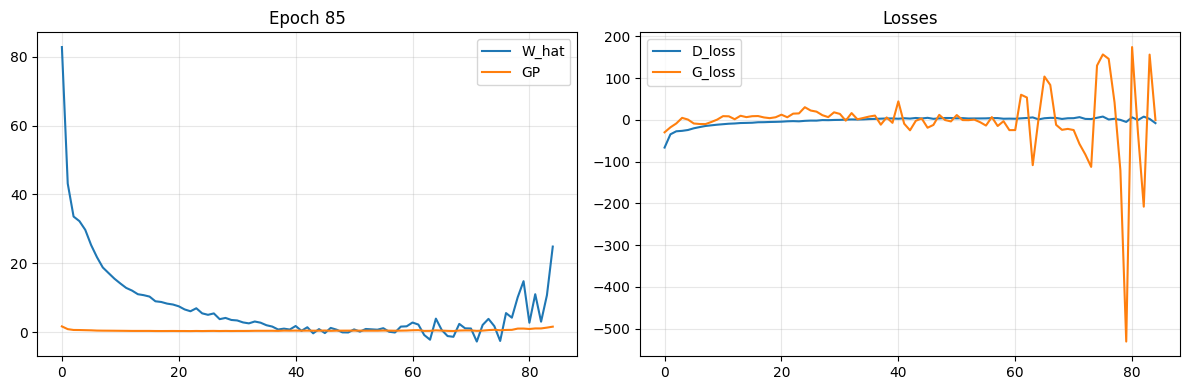

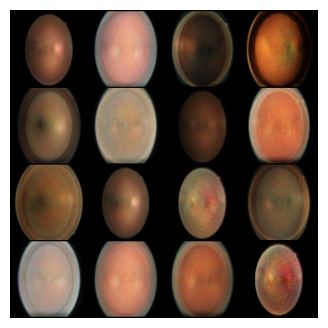

[Epoch 86/100] D_loss=15.6331 | G_loss=-70.7998 | W_hat=-3.3766 | GP=1.2121


[Epoch 87/100] D_loss=16.8721 | G_loss=93.6002 | W_hat=-2.4082 | GP=1.4435


[Epoch 88/100] D_loss=14.7795 | G_loss=-28.3427 | W_hat=-5.2170 | GP=1.0006


[Epoch 89/100] D_loss=-5.3768 | G_loss=-594.2385 | W_hat=22.0157 | GP=1.6806


[Epoch 90/100] D_loss=31.6873 | G_loss=-399.4475 | W_hat=-13.1703 | GP=1.8258


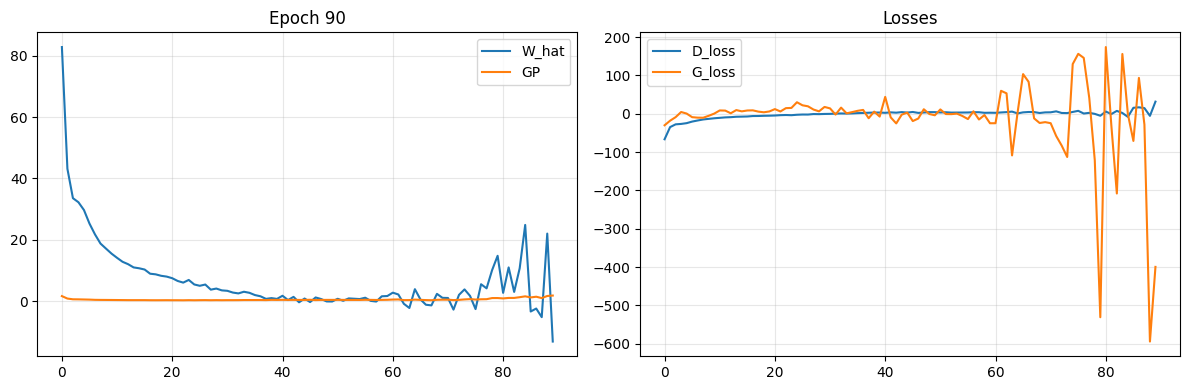

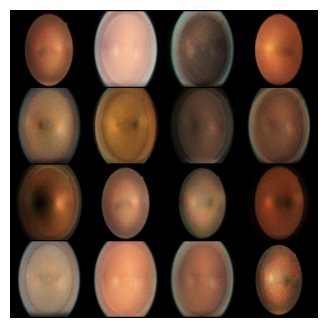

[Epoch 91/100] D_loss=28.8999 | G_loss=81.3224 | W_hat=-20.0083 | GP=0.8745


[Epoch 92/100] D_loss=21.6765 | G_loss=97.8148 | W_hat=-12.3018 | GP=0.9369


[Epoch 93/100] D_loss=15.7033 | G_loss=494.7766 | W_hat=-6.9777 | GP=0.8403


[Epoch 94/100] D_loss=8.0197 | G_loss=137.2079 | W_hat=-1.3177 | GP=0.6709


[Epoch 95/100] D_loss=16.1220 | G_loss=25.0692 | W_hat=-8.3000 | GP=0.7870


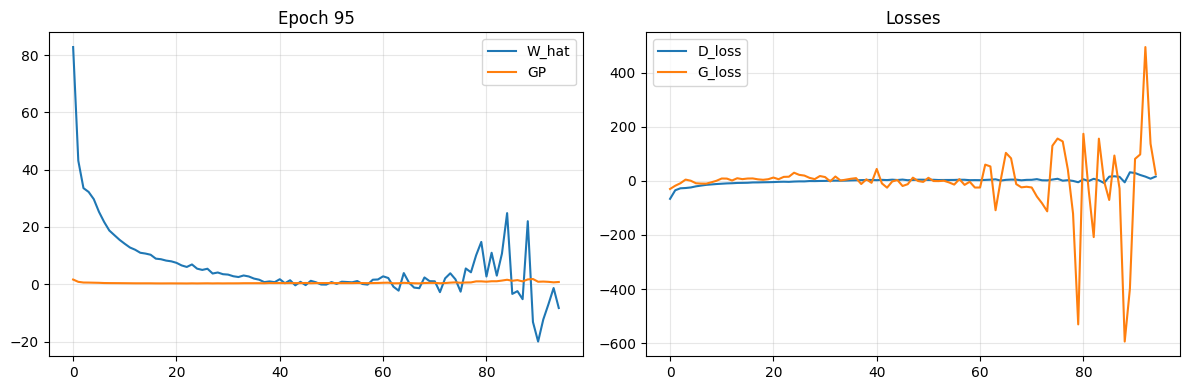

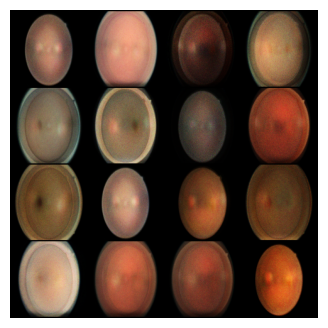

[Epoch 96/100] D_loss=2.1258 | G_loss=-210.4986 | W_hat=5.2947 | GP=0.7334


[Epoch 97/100] D_loss=7.5166 | G_loss=-73.4187 | W_hat=-0.2419 | GP=0.7038


[Epoch 98/100] D_loss=-0.3379 | G_loss=215.7338 | W_hat=11.9645 | GP=1.1521


[Epoch 99/100] D_loss=18.2617 | G_loss=-562.4178 | W_hat=-7.4470 | GP=1.0634


[Epoch 100/100] D_loss=-1.9631 | G_loss=-78.8102 | W_hat=13.4191 | GP=1.1499


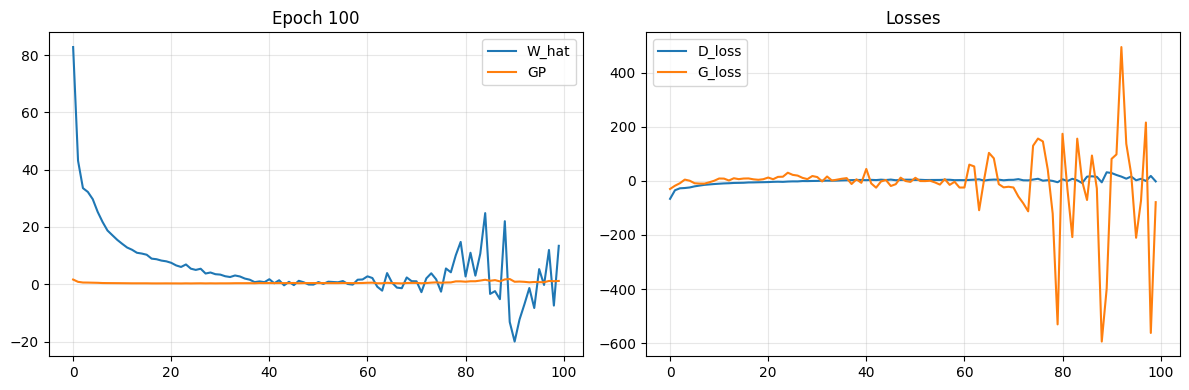

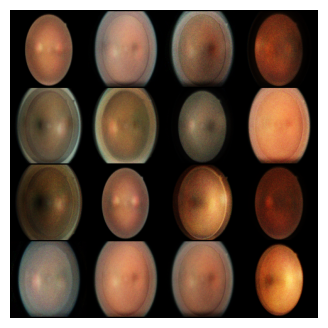

In [17]:
history = train(RUN_DIR, generator, discriminator, optimizer_G, optimizer_D)

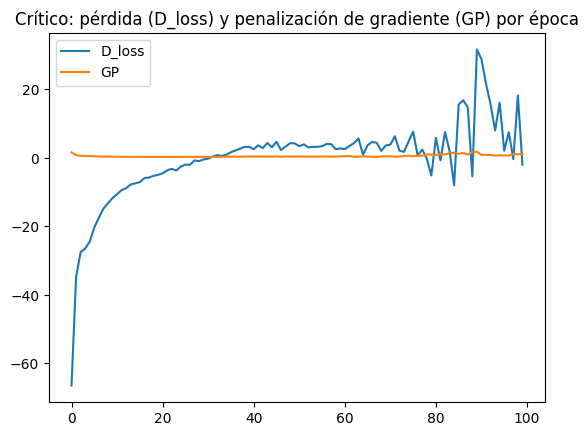

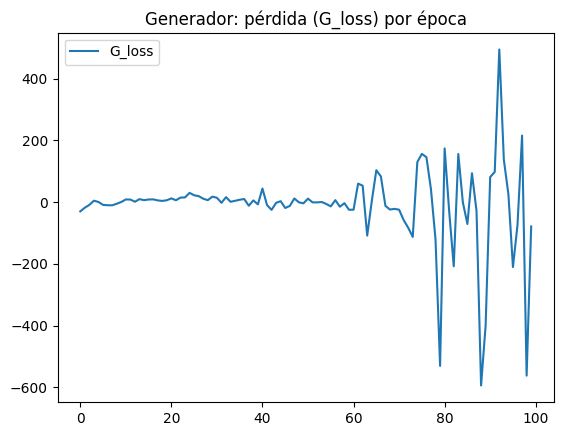

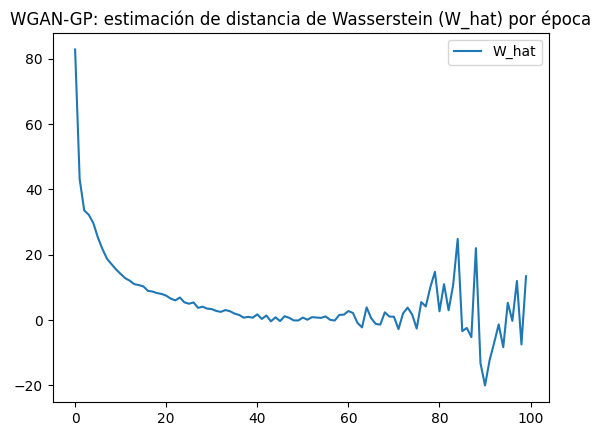

In [18]:
# Visualización

plt.figure()
plt.plot(history["d_loss"], label="D_loss")
plt.plot(history["gp"], label="GP")
plt.title("Crítico: pérdida (D_loss) y penalización de gradiente (GP) por época")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["g_loss"], label="G_loss")
plt.title("Generador: pérdida (G_loss) por época")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["W_hat"], label="W_hat")
plt.title("WGAN-GP: estimación de distancia de Wasserstein (W_hat) por época")
plt.legend()
plt.show()

## Conclusiones: 

(Checkpoint época 80)

A continuación **se cargan los pesos del generador correspondientes a la época 80**, ya que a partir de las curvas de entrenamiento (W_hat, pérdidas y GP) se observa
que en ese punto el modelo presenta mayor estabilidad antes de que comiencen oscilaciones pronunciadas en las últimas épocas.

Se comparan imágenes reales vs generadas para evaluar cualitativamente la calidad visual y la coherencia estructural de las retinografías sintéticas.

# Inferencia

In [ ]:
#Cargar checkpoint y volver a muestrear

# --- 1) Crear el modelo ---
generator = cWGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(DEVICE)

# --- 2) Cargar checkpoint ---
print("cWGAN (checkpoint 80)")
ckpt = os.path.join(RUN_DIR, "generator_1_80.pth")  # Se carga el generador entrenado (checkpoint de la época 80)
state = torch.load(ckpt, map_location=DEVICE)
generator.load_state_dict(state)
generator.eval()

cWGAN (checkpoint 80)


C:\Users\karin\AppData\Local\Temp\ipykernel_10752\967657548.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=DEVICE)


cWGAN_Generator(
  (label_emb): Embedding(5, 20)
  (model): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)


In [20]:
# Funciones Auxiliares

# Mapeo condición
COND_MAP = {
    "0right": 0, "1right": 1, "2right": 2, "3right": 3, "4right": 4,
    "0left":  0, "1left":  1, "2left":  2, "3left":  3, "4left":  4,
}

def make_condition(severity: int, side: str, n: int = 16, device=DEVICE):
    """
    Devuelve tensor (n,) con el id de condición repetido.
    """
    key = f"{severity}{side}"
    cond_id = COND_MAP.get(key, None)
    if cond_id is None:
        raise ValueError(f"Condición inválida: {key}. Usar side='right' o 'left' y severity 0..4.")
    return torch.full((n,), cond_id, dtype=torch.long, device=device)

def get_real_images_by_condition(dataset, cond_id: int, n: int = 16):
    """
    Extrae hasta n imágenes reales del dataset con condición = cond_id.
    Devuelve tensor (k,C,H,W). Si hay menos de n, devuelve k<n.
    """
    imgs = []
    for i in range(len(dataset)):
        x, c = dataset[i]
        if int(c.item()) == int(cond_id):
            imgs.append(x)
            if len(imgs) == n:
                break
    if len(imgs) == 0:
        return None
    return torch.stack(imgs, dim=0)

def sample_generator(G, n: int = 16, severity: int = 4, side: str = "right"):
    """
    Genera n imágenes para una condición dada.
    """
    G.eval()
    cond = make_condition(severity, side, n=n, device=DEVICE)
    with torch.no_grad():
        z = Tensor(np.random.normal(0, 1, (n, latent_dim))).to(DEVICE)
        fake = G(z, cond).detach().cpu()
    G.train()
    return fake  

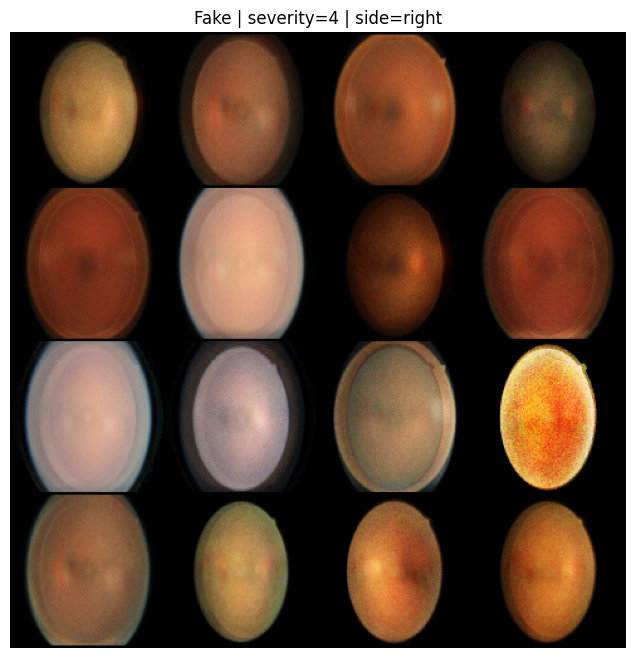

In [21]:
# Ejemplos

# 1) Generar y mostrar
fake_imgs = sample_generator(generator, n=16, severity=4, side="right")
show_grid(fake_imgs, title="Fake | severity=4 | side=right")

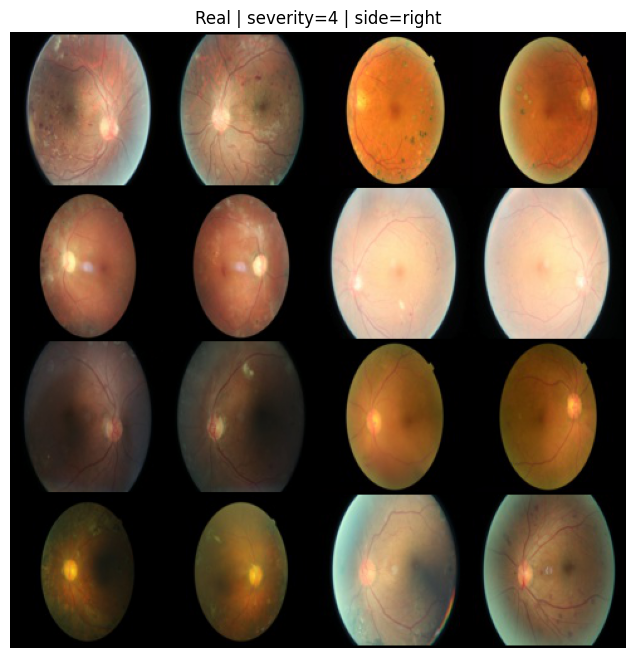

In [22]:
# 2) Mostrar reales de esa condición
cond0 = make_condition(4, "right", n=1, device=DEVICE)[0].cpu().item()
real_imgs = get_real_images_by_condition(dataset, cond_id=cond0, n=16)
show_grid(real_imgs, title="Real | severity=4 | side=right")

In [23]:
# 3) Guardar grillas
out_fake = os.path.join(SAMPLES_DIR, "fake_s4_right.png")
save_grid(fake_imgs, out_fake)

# Comparación visual y de distribuciones: datos reales vs generados

In [ ]:
# # Comparación visual y de distribuciones: datos reales vs generados

def show_real_fake_and_hist(dataset, G, severity=0, side="right", n=16):
    # ---- 1) condición ----
    cond_id = COND_MAP[f"{severity}{side}"]

    # ---- 2) juntar hasta n reales (vienen normalizadas en [-1,1]) ----
    real = []
    for i in range(len(dataset)):
        x, c = dataset[i]
        if int(c.item()) == cond_id:
            real.append(x)
            if len(real) == n:
                break

    if len(real) == 0:
        print(f"No se encontraron imágenes reales para sev={severity}, side={side}")
        return

    real = torch.stack(real, dim=0)  # (k,3,120,120) en [-1,1] por Normalize

    # ---- 3) generar n fake (sale en [-1,1] por Tanh) ----
    G.eval()
    with torch.no_grad():
        cond = torch.full((real.size(0),), cond_id, dtype=torch.long, device=DEVICE)
        z = Tensor(np.random.normal(0, 1, (real.size(0), latent_dim))).to(DEVICE)
        fake = G(z, cond).detach().cpu()  # (k,3,120,120) en [-1,1]
    G.train()

    # ---- 4) pasar AMBAS (real y fake) a [0,1] para visualizar y comparar ----
    real01 = ((real + 1) / 2).clamp(0, 1)
    fake01 = ((fake + 1) / 2).clamp(0, 1)

    # ---- 5) plot: grillas + hist ----
    fig = plt.figure(figsize=(12, 8))

    # Real grid
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title(f"REAL | sev={severity} | side={side}")
    ax1.axis("off")
    grid_real = vutils.make_grid(real01, nrow=4, padding=2)
    ax1.imshow(grid_real.permute(1, 2, 0))

    # Fake grid
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(f"FAKE | sev={severity} | side={side}")
    ax2.axis("off")
    grid_fake = vutils.make_grid(fake01, nrow=4, padding=2)
    ax2.imshow(grid_fake.permute(1, 2, 0))

    # Hist intensidades (en [0,1])
    ax3 = fig.add_subplot(2, 1, 2)
    r = real01.flatten().numpy()
    f = fake01.flatten().numpy()
    ax3.hist(r, bins=50, alpha=0.6, density=True, label="Real")
    ax3.hist(f, bins=50, alpha=0.6, density=True, label="Fake")
    ax3.set_title("Distribución de intensidades (pixel values) en [0,1]")
    ax3.set_xlabel("Intensidad")
    ax3.set_ylabel("Densidad")
    ax3.legend()

    plt.tight_layout()
    plt.show()

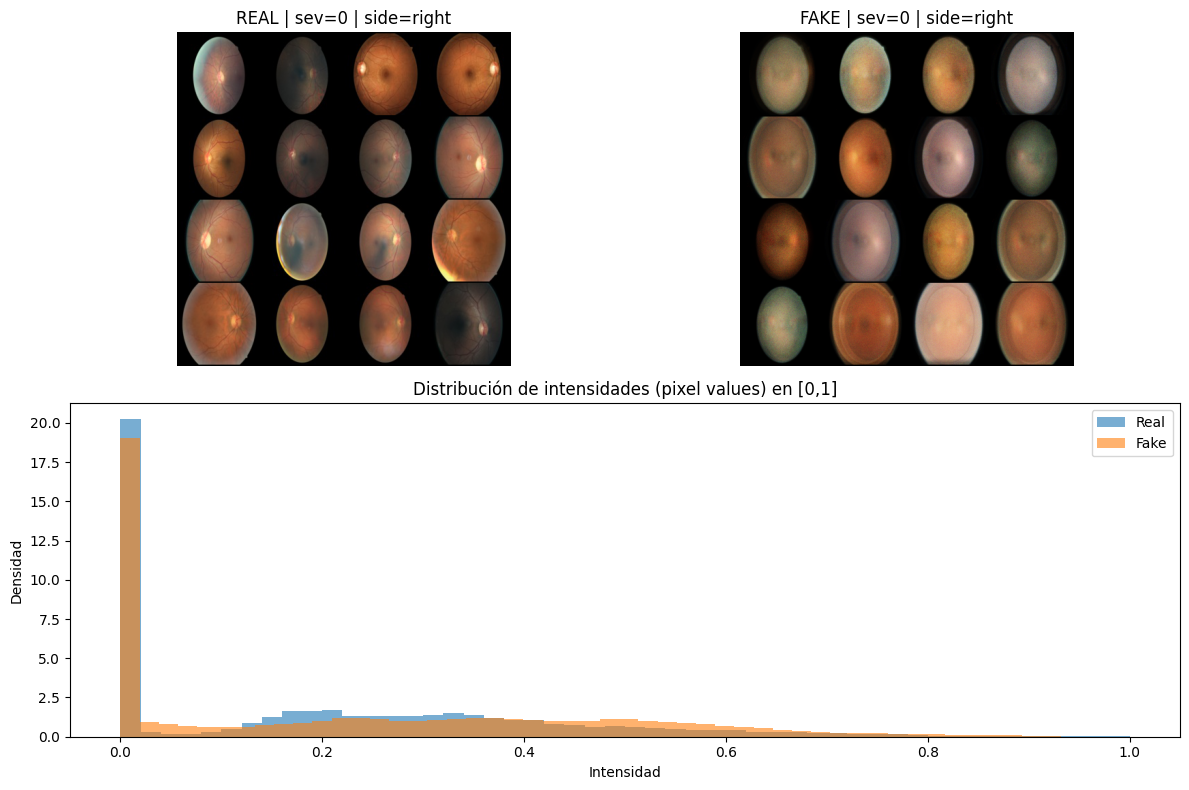

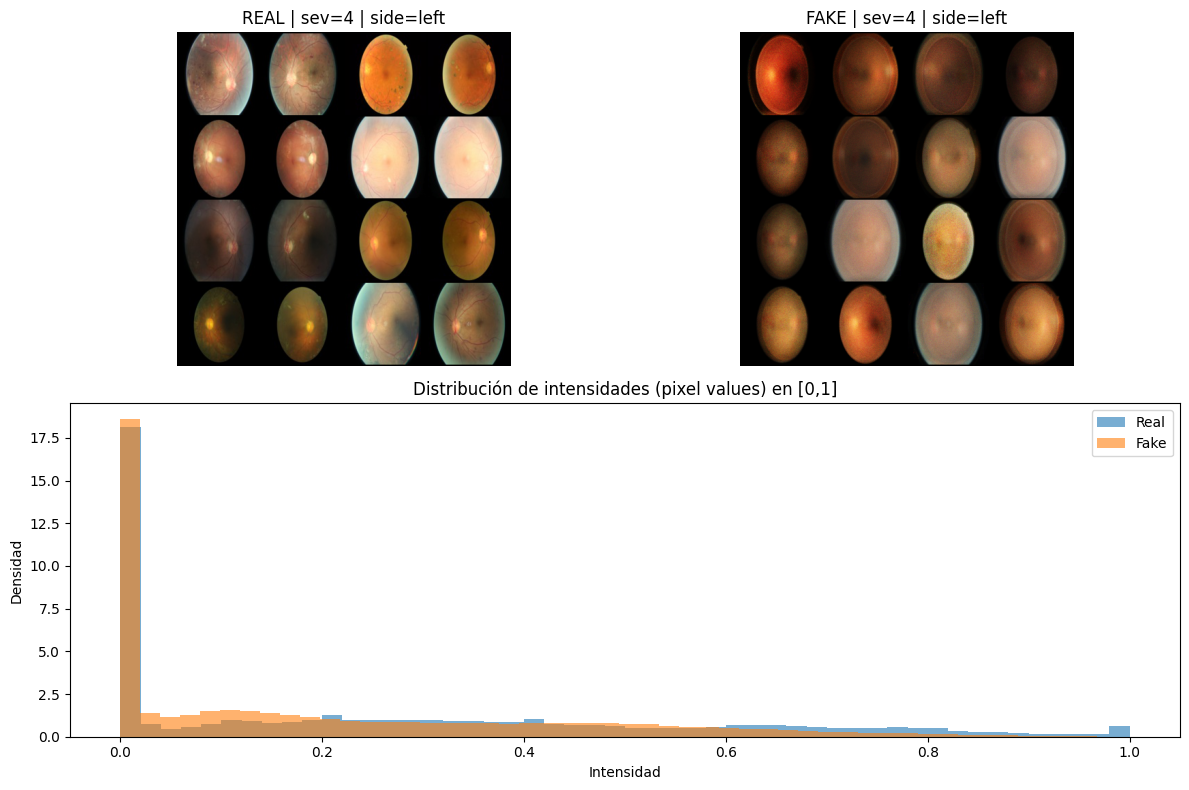

In [25]:
show_real_fake_and_hist(dataset, generator, severity=0, side="right", n=16)
show_real_fake_and_hist(dataset, generator, severity=4, side="left",  n=16)

# Métricas

## FID (Fréchet Inception Distance)

In [26]:
# Utilidades base 

# Escala un arreglo de imágenes a un tamaño dado
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# Resize mediante interpolación de vecino más cercano
		new_image = resize(image, new_shape, 0)
		# Almacenar la nueva imagen
		images_list.append(new_image)
	return asarray(images_list)


# Calcular FID
def calculate_fid(model, images1, images2):
	# calcular las activaciones con el modelo indicado
	act1 = model.predict(images1, verbose=0)
	act2 = model.predict(images2, verbose=0)
	# calcular media y covarianza
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calcular la suma de las diferencias de las medias al cuadrado
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calcular la raíz cuadrada del producto de covarianzas
	covmean = sqrtm(sigma1.dot(sigma2))
	# tomar la parte real para los números complejos
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calcular FID
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [27]:
# Conversión: PyTorch -> numpy NHWC en [0,255]

# Para usar el FID con el generador PyTorch (salida Tanh en [-1,1]):
# - Convertimos a [0,1]
# - Pasamos a NHWC
# - Escalamos a [0,255]

def torch_to_numpy_01_nhwc(x_torch):
    """
    x_torch: torch.Tensor (N,3,H,W) en [-1,1] o [0,1]
    return: np.ndarray (N,H,W,3) en [0,1]
    """
    x = x_torch.detach().cpu().float()
    # si viene en [-1,1], lo pasamos a [0,1]
    if x.min().item() < 0.0:
        x = (x + 1.0) / 2.0
    x = torch.clamp(x, 0.0, 1.0)
    x = x.permute(0, 2, 3, 1).numpy()  # NHWC
    return x

def prepare_images_for_fid_keras(images_nhwc_01):
    """
    images_nhwc_01: np.ndarray (N,H,W,3) en [0,1]
    return: np.ndarray (N,299,299,3) float32 preprocesado para InceptionV3 Keras
    """
    images = (images_nhwc_01 * 255.0).astype("float32")          # [0,255]
    images = scale_images(images, (299, 299, 3))                 # resize
    images = preprocess_input(images)                            # preprocess Keras
    return images

In [28]:
# ## Preparar InceptionV3 para FID

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# ## FID global (reales vs generadas)
#
# - Toma imágenes reales del dataloader (que están en [0,1] por ToTensor)
# - Genera fake con las mismas condiciones del batch
# - Calcula FID sobre N imágenes

@torch.no_grad()
def collect_real_fake_for_fid(generator, dataloader, latent_dim, n_images=500, device="cuda"):
    real_list = []
    fake_list = []
    count = 0

    generator.eval()
    for real_imgs, cond in dataloader:
        bs = real_imgs.size(0)
        cond = cond.to(device)
        real_imgs = real_imgs.to(device)

        z = torch.randn(bs, latent_dim, device=device)
        fake = generator(z, cond)  # [-1,1] por Tanh (en tu modelo)

        real_list.append(real_imgs.detach().cpu())
        fake_list.append(fake.detach().cpu())

        count += bs
        if count >= n_images:
            break

    real_all = torch.cat(real_list, dim=0)[:n_images]
    fake_all = torch.cat(fake_list, dim=0)[:n_images]
    generator.train()
    return real_all, fake_all

In [29]:
N_FID = 500  
real_t, fake_t = collect_real_fake_for_fid(generator, dataloader, latent_dim, n_images=N_FID, device=DEVICE)

# PyTorch -> numpy NHWC [0,1]
real_nhwc_01 = torch_to_numpy_01_nhwc(real_t)  # reales suelen venir en [0,1]
fake_nhwc_01 = torch_to_numpy_01_nhwc(fake_t)  # fake suele venir en [-1,1]

# preparar para Keras InceptionV3
real_proc = prepare_images_for_fid_keras(real_nhwc_01)
fake_proc = prepare_images_for_fid_keras(fake_nhwc_01)

fid_value = calculate_fid(model, real_proc, fake_proc)
print("FID (global): %.3f" % fid_value)

FID (global): 205.821


In [30]:
# FID por severidad (0..4)
# Este FID compara reales vs fake SOLO para una severidad (mezclando left/right).

@torch.no_grad()
def collect_real_fake_for_fid_by_severity(generator, dataloader, latent_dim, severity, n_images=500, device="cuda"):
    real_list = []
    fake_list = []
    count = 0

    generator.eval()
    for real_imgs, cond in dataloader:
        cond = cond.to(device)
        real_imgs = real_imgs.to(device)

        mask = (cond % 5) == severity
        if mask.sum() == 0:
            continue

        real_sel = real_imgs[mask]
        cond_sel = cond[mask]
        bs = real_sel.size(0)

        z = torch.randn(bs, latent_dim, device=device)
        fake = generator(z, cond_sel)

        real_list.append(real_sel.detach().cpu())
        fake_list.append(fake.detach().cpu())

        count += bs
        if count >= n_images:
            break

    if len(real_list) == 0:
        generator.train()
        return None, None

    real_all = torch.cat(real_list, dim=0)[:n_images]
    fake_all = torch.cat(fake_list, dim=0)[:n_images]
    generator.train()
    return real_all, fake_all

In [31]:
N_FID_PER_SEV = 500

for sev in range(5):
    real_t, fake_t = collect_real_fake_for_fid_by_severity(generator, dataloader, latent_dim, severity=sev, n_images=N_FID_PER_SEV, device=DEVICE)
    if real_t is None:
        print(f"FID | severity={sev}: no hay suficientes imágenes.")
        continue

    real_nhwc_01 = torch_to_numpy_01_nhwc(real_t)
    fake_nhwc_01 = torch_to_numpy_01_nhwc(fake_t)

    real_proc = prepare_images_for_fid_keras(real_nhwc_01)
    fake_proc = prepare_images_for_fid_keras(fake_nhwc_01)

    fid = calculate_fid(model, real_proc, fake_proc)
    print("FID | severity=%d: %.3f" % (sev, fid))

FID | severity=0: 211.877
FID | severity=1: 207.615
FID | severity=2: 196.485
FID | severity=3: 203.948
FID | severity=4: 185.512


## Métrica IS (Inception Score)

La Inception Score (IS) evalúa las imágenes generadas usando un clasificador InceptionV3 preentrenado.
- Busca que cada imagen sea "fácil de clasificar" (baja entropía en p(y|x)).
- Y que el conjunto sea diverso (alta entropía en p(y)).

Definición:
IS = exp( E_x [ KL( p(y|x) || p(y) ) ] )

In [32]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# cargar el modelo inception v3
	model = InceptionV3()
	# convertir a punto flotante
	processed = images.astype('float32')
	# preprocesar imágenes para el modelo inception v3
	processed = preprocess_input(processed)
	# predecir la probabilidad de cada clase
	yhat = model.predict(processed, verbose=0)
	# enumerar particiones de imágenes y predicciones
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# recuperar p(y|x)
		ix_start, ix_end = i * n_part, i * n_part + n_part
		p_yx = yhat[ix_start:ix_end]
		# calcular p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calcular KLD (usando log de las probabilidades)
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# suma sobre clases y promedio sobre imágenes
		sum_kl_d = kl_d.sum(axis=1)
		avg_kl_d = mean(sum_kl_d)
		# revertir el logaritmo y almacenar
		is_score = exp(avg_kl_d)
		scores.append(is_score)
	# promedio sobre particiones
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [33]:
# Conversión: PyTorch (N,C,H,W) en [-1,1] -> Keras (N,299,299,3) en [0,255]
# - Entrada esperada: batch_fake_torch (tensor PyTorch) en [-1,1], shape (N,3,120,120)
# - Salida: numpy array uint8/float en shape (N,299,299,3) en [0,255]

def torch_to_keras_images_299(fake_torch):
    """
    fake_torch: torch.Tensor (N,3,H,W) en [-1,1]
    return: np.ndarray (N,299,299,3) en [0,255]
    """
    # [-1,1] -> [0,1]
    x = (fake_torch.detach().cpu().float() + 1.0) / 2.0
    x = torch.clamp(x, 0.0, 1.0)

    # resize a 299x299
    x = torch.nn.functional.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

    # NCHW -> NHWC
    x = x.permute(0, 2, 3, 1).numpy()

    # [0,1] -> [0,255]
    x = (x * 255.0)
    return x


# IS global 
# Se generan imágenes usando el generador, se convierten a formato Keras y se calcula IS.

def compute_is_global(generator, dataloader, latent_dim, n_images=500, n_split=10, device=DEVICE):
    """
    Calcula IS para imágenes generadas tomando condiciones del dataloader.
    - n_images: cantidad total aproximada de imágenes a usar
    """
    generator.eval()
    batches = []
    count = 0

    with torch.no_grad():
        for real_imgs, cond in dataloader:
            bs = real_imgs.size(0)
            cond = cond.to(device)

            z = torch.randn(bs, latent_dim, device=device)
            fake = generator(z, cond)  # [-1,1]
            batches.append(fake)

            count += bs
            if count >= n_images:
                break

    fake_all = torch.cat(batches, dim=0)[:n_images]
    images_keras = torch_to_keras_images_299(fake_all)

    # asegurar suficiente N para n_split
    if images_keras.shape[0] < n_split:
        raise ValueError(f"No hay suficientes imágenes para n_split={n_split}. N={images_keras.shape[0]}")

    is_avg, is_std = calculate_inception_score(images_keras, n_split=n_split)
    generator.train()
    return is_avg, is_std

In [34]:
IS_avg, IS_std = compute_is_global(generator, dataloader, latent_dim, n_images=500, n_split=10, device=DEVICE)
print(f"IS global: {IS_avg:.3f} ± {IS_std:.3f}")

IS global: 2.034 ± 0.106


In [35]:
# IS por severidad
# Se calcula IS sobre imágenes generadas filtrando por severidad (mezclando left/right).

def compute_is_by_severity(generator, dataloader, latent_dim, severity, n_images=500, n_split=10, device=DEVICE):
    generator.eval()
    batches = []
    count = 0

    with torch.no_grad():
        for real_imgs, cond in dataloader:
            cond = cond.to(device)

            mask = (cond % 5) == severity
            if mask.sum() == 0:
                continue

            cond_sel = cond[mask]
            bs = cond_sel.size(0)

            z = torch.randn(bs, latent_dim, device=device)
            fake = generator(z, cond_sel)  # [-1,1]

            batches.append(fake)
            count += bs
            if count >= n_images:
                break

    if len(batches) == 0:
        generator.train()
        return None

    fake_all = torch.cat(batches, dim=0)[:n_images]
    images_keras = torch_to_keras_images_299(fake_all)

    # asegurar suficiente N para n_split
    if images_keras.shape[0] < n_split:
        generator.train()
        return None

    is_avg, is_std = calculate_inception_score(images_keras, n_split=n_split)
    generator.train()
    return is_avg, is_std, images_keras.shape[0]

In [36]:
N_IS_PER_SEV = 500
SPLITS_IS = 10

for sev in range(5):
    out = compute_is_by_severity(generator, dataloader, latent_dim, severity=sev, n_images=N_IS_PER_SEV, n_split=SPLITS_IS, device=DEVICE)
    if out is None:
        print(f"IS | severity={sev}: no hay suficientes imágenes.")
        continue
    is_avg, is_std, n_used = out
    print(f"IS | severity={sev}: {is_avg:.3f} ± {is_std:.3f}   (N={n_used})")

IS | severity=0: 2.063 ± 0.154   (N=500)
IS | severity=1: 2.014 ± 0.147   (N=500)
IS | severity=2: 1.996 ± 0.077   (N=500)
IS | severity=3: 1.840 ± 0.101   (N=500)
IS | severity=4: 1.859 ± 0.109   (N=500)
